## Example for $n$ Qubits

both libraries needed to use the following program

In [898]:
#%pip install qiskit
#%pip install qiskit[visualization]

In [899]:
#initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, execute
from qiskit import QuantumCircuit
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# import of plot tool
from qiskit.visualization import plot_histogram

you can try to skip the next step with the token first, to see, if it works without

You might need to sign into or register at https://quantum-computing.ibm.com/lab, get your token in the dashboard and paste it here:

In [900]:
# MY_TOKEN = 'TOKEN HERE'
# IBMQ.save_account(MY_TOKEN)

function to add the oracle for any number of winners $w$

In [901]:
def apply_oracle(winners : list, n_qubits, circuit):
   oracle = QuantumCircuit(n_qubits)
   for winner in winners:
      if winner > 2**n_qubits:
         raise ValueError('One of the given winners value is too big')
      for i in range(n):
         if ((winner >> i) & 1)==0:
            oracle.x(i)
      oracle.h(n_qubits-1)
      oracle.mct(list(range(n_qubits-1)), n_qubits-1)  # multi-controlled-toffoli
      oracle.h(n_qubits-1)
      for i in range(n_qubits):
         if ((winner >> i) & 1)==0:
            oracle.x(i)
   oracle = oracle.to_gate()
   oracle.name = "$U_w$"
   circuit.append(oracle, list(range(n_qubits)))

In [902]:
# amount of qubits
n = 3

# amount of different possible states in the list
N = 2**n

# which entries to search for 
# choose your own, but try not to use more than 2,
# because the result will not be accurate yet (hard to fix)
# it makes it easier to compare the results and marks, if the marks are put in as binaries like 0b101
mark = [0b110]

In [903]:
# creating oracle circuit
oracle_n = QuantumCircuit(n)

# applying oracle with the marks we set
apply_oracle(mark,n,oracle_n)

# show oracle
oracle_n.draw()

# make oracle to a gate
oracle_n = oracle_n.to_gate()
oracle_n.name = "U$_w$"

In [904]:
# general diffuser for any number of qubits
def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits)

    # get qubits out of superposition
    for qubit in range(n_qubits):
        qc.h(qubit)

    # NOT gate on every qubit
    for qubit in range(n_qubits):
        qc.x(qubit)

    # Do multi-controlled-Z gate
    qc.h(n_qubits-1)
    qc.mct(list(range(n_qubits-1)), n_qubits-1)  # multi-controlled-CX-gate
    qc.h(n_qubits-1)

    # NOT gate on every qubit
    for qubit in range(n_qubits):
        qc.x(qubit)

    # apply superposition on every qubit
    for qubit in range(n_qubits):
        qc.h(qubit)
    # We will return the diffuser as a gate with U_s as name
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [905]:
# initialization function, which puts every qubit in superposition
def init_qubits(circuit, qubits):
   for qubit in qubits:
        circuit.h(qubit)
   return circuit

In [906]:
# one grover iteration
# each iteration adds the oracle and diffuser again to the circuit
def grover_iteration(circuit, n):
   apply_oracle(mark, n, circuit)
   circuit.append(diffuser(n),list(range(n)))
   

- create circuit for grover's algorithm 
- apply superposition on every qubit
- do $\pi / 4 * \sqrt{N}$ iterations

In [907]:
# create circuit for grover's algorithm 
grover_circuit = QuantumCircuit(n)

# apply superposition on every qubit
grover_circuit = init_qubits(grover_circuit, list(range(n)))

# do np.pi/4 * np.sqrt(N) iterations
# for i in range(int(np.pi/4 * np.sqrt(N))):
#     grover_iteration(grover_circuit,n)

# the above approach with iterations does not work properly, 
# so one iteration is enough, if the number of winners is not too high
grover_iteration(grover_circuit,n)

# apply measure gate on every qubit
grover_circuit.measure_all()

grover_circuit.draw()

┌───┐┌────────┐┌────────┐ ░ ┌─┐            
   q_0: ┤ H ├┤0       ├┤0       ├─░─┤M├────────────
        ├───┤│        ││        │ ░ └╥┘┌─┐         
   q_1: ┤ H ├┤1       ├┤1       ├─░──╫─┤M├─────────
        ├───┤│        ││        │ ░  ║ └╥┘┌─┐      
   q_2: ┤ H ├┤2 $U_w$ ├┤2 U$_s$ ├─░──╫──╫─┤M├──────
        ├───┤│        ││        │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ H ├┤3       ├┤3       ├─░──╫──╫──╫─┤M├───
        ├───┤│        ││        │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤ H ├┤4       ├┤4       ├─░──╫──╫──╫──╫─┤M├
        └───┘└────────┘└────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

In [908]:
# select a provider 
# in this case an actual quantum computer, not a simulator
provider = IBMQ.get_provider("ibm-q")

In [909]:
# try least busy instead
# backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
#                                   not x.configuration().simulator and x.status().operational==True))

In [910]:
# use ibmq_belem, which is one of the less busier QCs
# or use the code in the cell above and comment this cell's code
backend = provider.get_backend('ibmq_belem')


In [911]:
# execute the circuit with 10.000 shots (can be put up to 20.000)
job = execute(grover_circuit, backend, shots=10000)


In [912]:
# look if the job is done
job_monitor(job, interval=2)

Job Status: job has successfully run


In [913]:
# get results
results = job.result()

# get the counts of each possible state
answer = results.get_counts(grover_circuit)


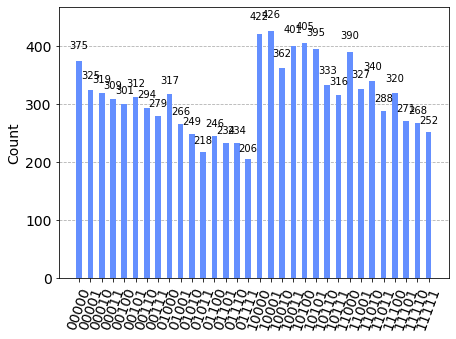

In [914]:
plot_histogram(answer)